# Imports
(Based on Python 3.5)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import NearestNeighbors

c:\program files\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\program files\python35\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 1 Pre-steps

## 1.0 Reading data

In [2]:
# reading data
X_train_fname = 'training_templates.csv'
y_train_fname = 'training_labels.txt'
X_test_fname  = 'testing_templates.csv'
X_train = pd.read_csv(X_train_fname, sep=',', header=None).values
y_train = np.loadtxt(y_train_fname, dtype=np.int)
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None).values

[n,p]=X_train.shape

In [3]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# PCA
pca = PCA(n_components=128)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)

## 1.1 Data Standardization

In [3]:
# Data Standardization

# test the role of Standardization
clf = SVC(C=1, kernel='rbf')

# Prediction 
ind=np.random.permutation(n)
X=X_train[ind][:20000]
y=y_train[ind][:20000]
print('cross validation score without standardization:',np.mean(cross_val_score(clf, X, y, cv=4)))

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X=X_train[ind][:20000]
y=y_train[ind][:20000]
print('cross validation score with standardization:',np.mean(cross_val_score(clf, X, y, cv=4)))

cross validation score without standardization: 0.91325026653
cross validation score with standardization: 0.978299899132


## 1.2 PCA

In [4]:
# PCA
pca = PCA(n_components=128)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)

X=X_train[ind][:20000]
y=y_train[ind][:20000]
print('cross validation score with PCA:',np.mean(cross_val_score(clf, X, y, cv=4)))

cross validation score with PCA: 0.978299899132


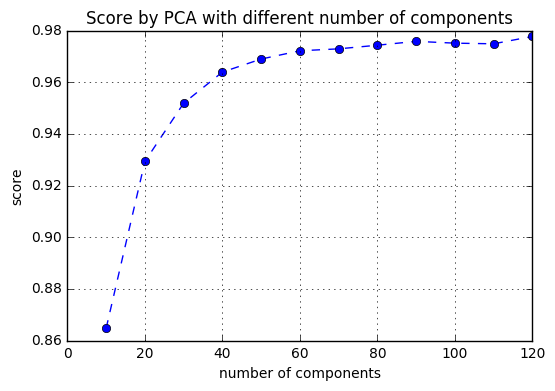

In [18]:
# # see the effect of n_components of PCA
# score_PCA=list([])
# for n_components in range(10,128,10):
#     pca = PCA(n_components=n_components)
#     X=pca.fit_transform(X_train)
#     ind=np.random.permutation(n)
#     X=X[ind][:20000]
#     y=y_train[ind][:20000]
#     clf = SVC(C=1, kernel='rbf')
#     score_PCA.append(np.mean(cross_val_score(clf, X, y, cv=4)))
#     print('n_components=',n_components,',score=',np.mean(cross_val_score(clf, X, y, cv=4)))
# plt.plot(range(10,128,10),score_PCA,'--',marker='o')
# plt.title('Score by PCA with different number of components')
# plt.xlabel('number of components')
# plt.ylabel('score')
# plt.grid()
# plt.show()

## 1.3 Data deduction via KNN

In [4]:
# KNN with 10 nearest neighbors

neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(X_train[:,:p/2])
s=neigh.kneighbors(X_test[:,:p/2], return_distance=False)
select=list([])
for i in s:
    for j in i:
        select.append(j)
select=list(set(select))
X_select=X_train[select,:]
y_select=y_train[select]

print("we've selected %d samples from entire X_train" % X_select.shape[0])

c:\program files\python35\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\program files\python35\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


we've selected 38943 samples from entire X_train


## 1.4 Determine the predicted labels

In [5]:
# performance criteria
def compute_pred_score(y_true, y_pred):
    y_pred_unq =  np.unique(y_pred)
    for i in y_pred_unq:
        if((i != -1) & (i!= 1) & (i!= 0) ):
            raise ValueError('The predictions can contain only -1, 1, or 0!')
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

# determine label for testing sets
def determine(x,positive,threshold):
    y_pred=np.zeros(len(x))
    for i in range(len(y_pred)):
        if x[i,0]<threshold:
            y_pred[i]=-positive
        elif x[i,0]>1-threshold:
            y_pred[i]=positive
        else:
            y_pred[i]=0
    return y_pred

# 2 Classifiers

## 2.1 SVM

In [ ]:
# SVM classification with probability=True
clf = SVC(C=1, kernel='rbf', probability=True, cache_size=7000, class_weight='balanced')
n,p=X_select.shape
ind=np.random.permutation(n)
X_train=X_train[ind]
y_train=y_train[ind]

begin = time.time()
clf.fit(X_select[0:20000], y_select[0:20000])
cost = time.time() - begin

# Prediction
y_pred=clf.predict_proba(X_select[20000:])
y_pred=determine(y_pred,clf.classes_[0],0.1)
# Compute the score
score = compute_pred_score ( y_select[20000:] , y_pred ) 
print ( 'Training score: % s ' % score )
print('Training time: % s seconds' % cost)


In [11]:
# SVM classification with probability=False
clf = SVC(C=2, kernel='rbf', probability=False, cache_size=7000, class_weight='balanced')
n,p=X_select.shape
ind=np.random.permutation(n)
X_select=X_select[ind]
y_select=y_select[ind]

begin = time.time()
clf.fit(X_select[0:20000], y_select[0:20000])
# print('Best estimator:',clf.best_estimator_)
cost = time.time() - begin

# Prediction
y_pred=clf.predict(X_select[20000:])
dist=clf.decision_function(X_select[20000:])
y_pred[dist<0.95*min(dist)+0.05*max(dist)]=0
# Compute the score
score = compute_pred_score ( y_select[20000:] , y_pred ) 
print ( 'Training score: % s ' % score )
print ('Training time: % s seconds' % cost)

Training score: 0.19168030407010506 
Training time: 466.835693359375 seconds


## 2.2 Random forest

In [9]:
# Random Forest
clf = RandomForestClassifier(n_estimators=50)

# clf = RandomizedSearchCV(clf, param_distributions={
#     'max_depth': stats.uniform(1,30),
#     'max_features':stats.uniform(0.5,1)})

n,p=X_select.shape
ind=np.random.permutation(n)
X_select=X_select[ind]
y_select=y_select[ind]
begin = time.time()
clf.fit(X_select[:20000], y_select[:20000])
# print(clf.best_estimator_)
cost = time.time() - begin

# Prediction 
y_pred=clf.predict_proba(X_select[20000:])
y_pred=determine(y_pred,clf.classes_[0],0.1)
# Compute the score
score = compute_pred_score ( y_select[20000:] , y_pred ) 
print ( 'Training score: % s ' % score )
print('Training time: % s seconds' % cost)

Training score: 0.9289975188724067 
Training time: 89.1927399635315 seconds


## 2.3 MLP

## 2.3.1 MLP Classifier Parameter optimisation

In [20]:
# Optimise parameters
clf = MLPClassifier(solver='adam',validation_fraction=0.3)

clf = RandomizedSearchCV(clf, param_distributions={
        'alpha': stats.uniform(0.005,0.01),
        'learning_rate_init': stats.uniform(0.0001,0.0005),
        'activation':['identity', 'logistic', 'tanh', 'relu'],
        'hidden_layer_sizes':[(200,),(220,),(240,),(260,),(280,),(300,)]})
clf.fit(X_select, y_select)
print(clf.best_estimator_)

MLPClassifier(activation='relu', alpha=0.012337222794656134,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=True,
       epsilon=1e-08, hidden_layer_sizes=(260,), learning_rate='adaptive',
       learning_rate_init=0.00036445635408383824, max_iter=200,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.3,
       verbose=False, warm_start=False)

## 2.3.2 MLP Classifier cross validation

In [14]:
# Multi-layer Perceptron Classifier
clf=MLPClassifier(activation='relu', alpha=0.012337222794656134,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=True,
       epsilon=1e-08, hidden_layer_sizes=(260,), learning_rate='adaptive',
       learning_rate_init=0.00036445635408383824, max_iter=500,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.3,
       verbose=False, warm_start=False)
clf=BaggingClassifier(base_estimator=clf, n_estimators=10)

n,p=X_select.shape
scaler.fit(X_select)
X_select = scaler.transform(X_select)
X_test = scaler.transform(X_test)
ind=np.random.permutation(n)
X_select=X_select[ind]
y_select=y_select[ind]
begin = time.time()

clf.fit(X_select[:30000], y_select[:30000])
cost = time.time() - begin

# Prediction 
y_pred=clf.predict_proba(X_select[30000:])
y_pred=determine(y_pred,clf.classes_[0],0.1)
# Compute the score
score = compute_pred_score ( y_select[30000:] , y_pred ) 
print ( 'Training score: % s ' % score )
print('Training time: % s seconds' % cost)

Training score: 0.14312870401431288 
Training time: 520.441855430603 seconds


## 2.3.3 Boosting recursively

In [15]:
# Boosting
X_train_=X_select
y_train_=y_select
zeros1=0
zeros2=1
while zeros2>zeros1:
    y_pred_=y_pred
    zeros1=zeros2
    clf.fit(X_train_, y_train_)
    y_pred=clf.predict_proba(X_test)
    y_pred=determine(y_pred,clf.classes_[0],0.1)
    zeros2=y_pred[y_pred!=0].shape[0]
    X_train_=np.r_[X_select, X_test[y_pred!=0]]
    y_train_=np.r_[y_select, y_pred[y_pred!=0]]
    print('Exactly estimate %4.2f' %(zeros2/X_test.shape[0]*100), '% of test dataset.')
    np.savetxt('y_pred.txt', y_pred_, fmt='%d')

Exactly estimate 89.08 % of test dataset.
Exactly estimate 94.39 % of test dataset.
Exactly estimate 95.39 % of test dataset.
Exactly estimate 95.88 % of test dataset.
Exactly estimate 95.99 % of test dataset.
Exactly estimate 96.05 % of test dataset.
Exactly estimate 95.96 % of test dataset.


In [22]:
y1 = np.loadtxt('y_pred 0.128531073446.txt', dtype=np.int)
y2 = np.loadtxt('y_pred 0.126883239171.txt', dtype=np.int)
print(y1[y1==0].shape)
y1[y1==0]=y2[y1==0]
print(y1[y1==0].shape)
np.savetxt('y111.txt', y1, fmt='%d')

(344,)
(225,)
